# Libraries

In [13]:
import gym
import random
import ray
import tensorflow as tf
import utils
from gym import spaces
from ray.rllib.algorithms.sac import SAC
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.algorithms.sac.sac_tf_model import SACTFModel
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.typing import ModelConfigDict, TensorType
from environments.knapsack import KnapsackEnv

# Define Custom Model

In [14]:
class CustomTFModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name
        )

        weight_inputs = tf.keras.layers.Input(shape=obs_space['observations']['observation_weights'].shape, name='observation_weights')
        value_inputs = tf.keras.layers.Input(shape=obs_space['observations']['observation_values'].shape, name='observation_values')
        knapsack_inputs = tf.keras.layers.Input(shape=obs_space['observations']['observation_knapsack'].shape, name='observation_knapsack')
        inputs = tf.keras.layers.Concatenate(axis=-1)([weight_inputs, value_inputs, knapsack_inputs])
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_1')(inputs)
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_2')(x)
        policy_out = tf.keras.layers.Dense(units=num_outputs, name='policy_out')(x)
        value_out = tf.keras.layers.Dense(units=1, name='value_out')(x)
        self.base_model = tf.keras.Model([weight_inputs, value_inputs, knapsack_inputs], [policy_out, value_out])

    def forward(self, input_dict, state, seq_lens):
        action_mask = input_dict['obs']['action_mask']
        observations = input_dict['obs']['observations']

        model_out, self._value_out = self.base_model(observations)
        masked_model_out = model_out + tf.maximum(tf.math.log(action_mask), tf.float32.min)
        return masked_model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])


class SACCustomModel(SACTFModel):
    def __init__(
            self,
            obs_space: spaces.Space,
            action_space: spaces.Space,
            num_outputs: int,
            model_config: ModelConfigDict,
            name: str,
            policy_model_config: ModelConfigDict=None,
            q_model_config: ModelConfigDict=None,
            twin_q: bool=False,
            initial_alpha: float=1.0,
            target_entropy: float=None,
    ):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name,
            policy_model_config=policy_model_config,
            q_model_config=q_model_config,
            twin_q=twin_q,
            initial_alpha=initial_alpha,
            target_entropy=target_entropy
        )

    def build_policy_model(self, obs_space, num_outputs, policy_model_config, name):
        orig_space = getattr(obs_space, "original_space", obs_space)

        assert (
                isinstance(orig_space, gym.spaces.Dict)
                and "action_mask" in orig_space.spaces
                and "observations" in orig_space.spaces
        )

        return CustomTFModel(
            obs_space=orig_space,
            action_space=self.action_space,
            num_outputs=num_outputs,
            model_config=policy_model_config,
            name=name
        )

    def build_q_model(self, obs_space, action_space, num_outputs, q_model_config, name):
        orig_space = getattr(obs_space, "original_space", obs_space)

        assert (
                isinstance(orig_space, gym.spaces.Dict)
                and "action_mask" in orig_space.spaces
                and "observations" in orig_space.spaces
        )

        return CustomTFModel(
            obs_space=orig_space,
            action_space=self.action_space,
            num_outputs=num_outputs,
            model_config=q_model_config,
            name=name
        )

# Train Masked Model

2023-01-06 19:46:25,489	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-06 19:46:26,871	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'environments.knapsack.KnapsackEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'environments.knapsack.KnapsackEnv'>').build()` instead. This will raise an error in the future!
2023-01-06 19:46:29,208	WARNING util.py:66 -- Install gputil for GPU system monitoring.


--- Policy Model ---
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observation_weights (InputLaye  [(None, 10)]        0           []                               
 r)                                                                                               
                                                                                                  
 observation_values (InputLayer  [(None, 10)]        0           []                               
 )                                                                                                
                                                                                                  
 observation_knapsack (InputLay  [(None, 1)]         0           []                               
 er)                                                                   

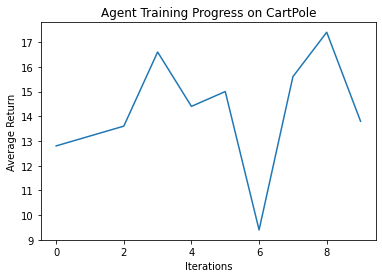

[12.8, 13.2, 13.6, 16.6, 14.4, 15.0, 9.4, 15.6, 17.4, 13.8]

In [15]:
ray.shutdown()
ray.init()
ModelCatalog.register_custom_model("sac_model", SACCustomModel)
tf.random.set_seed(seed=0)
random.seed(0)
agent = SAC(env=KnapsackEnv, config={
    'env_config': {},
    'model': {
        'custom_model': 'sac_model',
        'custom_model_config': {}
    },
    'replay_buffer_config' : {
        "type": 'MultiAgentPrioritizedReplayBuffer',
        'prioritized_replay': True,
        "capacity": 50000,
        'prioritized_replay_alpha': 0.6,
        'prioritized_replay_beta': 0.4,
        'prioritized_replay_eps': 1e-6,
        'replay_sequence_length': 1,
    },
    'num_steps_sampled_before_learning_starts': 5000,
    'target_network_update_freq': 1,
    'tau': 0.005,
    'train_batch_size': 256,
    'n_step': 3,
    'twin_q': True,
    'initial_alpha': 1.0,
    'target_entropy': 'auto',
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.001,
    'num_gpus': 1
})
print('--- Policy Model ---')
agent.get_policy().target_model.action_model.base_model.summary(expand_nested=True)
print('--- Q-Model Model ---')
agent.get_policy().target_model.q_net.base_model.summary(expand_nested=True)
utils.train(agent=agent, train_iterations=10, eval_env=KnapsackEnv(env_config={}))